# Lucas Oliveira Machado de Sousa

# TP Graphs

In this TP, we will try out different techniques for clustering graphs, and later on, for matching two graphs of different sizes.


#### Important: Updating Colab's NumPy version
For some of the algorithms made available in the `scikit-network` library, we need a different version of NumPy from the one installed in Colab. When first starting the runtime, please run the following code cell once. It will ask you to restart the runtime to complete the installation; please do so. You may now proceed with the rest of the TP.

In [1]:
!pip install numpy==1.21.4

     |████████████████████████████████| 15.7 MB 9.4 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.4 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [1]:
!pip install scikit-network==0.23.1

from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nibabel as nib

from scipy.sparse.csgraph import laplacian as csgraph_laplacian
from scipy.sparse.linalg import eigsh
from scipy import sparse

import networkx as nx

from skimage import data, segmentation, color, io, transform, filters, util
from skimage.future import graph as skgraph
from skimage.measure import regionprops, label as sklabel

from sklearn.cluster import KMeans, SpectralClustering

from sknetwork.clustering import Louvain
from sknetwork.data import karate_club


## Clustering

In this part, we will perform unsupervised clustering of graphs using different techniques. For the first exercises, we will build a toy graph for experimenting with the clustering techniques. In the second exercise, we will build a graph from an image segmentation and attempt to cluster it.

###  Creating a graph

There are two main Python libraries for working with graphs - [NetworkX](https://networkx.org/documentation/networkx-1.10/index.html) (often imported as `nx`) and [scikit-network](https://networkx.org/documentation/networkx-1.10/reference/introduction.html). 

Each of them represents graphs differently: 
* NetworkX uses objects, with class representing basic graph types (such as `Graph` for an undirected graph and `DiGraph` for a directed graph). This allows for more powerful representations (with multiple attributes per node or edge) at the cost of higher overhead.
* scikit-network uses the graph's adjacency matrix directly (stored as a `scipy` sparse matrix).

Converting between them is easy: to generate a NetworkX graph object from a sparse matrix, we use the `nx.convert_matrix.from_scipy_sparse_matrix(adjacency_matrix)` method. Inversely, we can get the sparse matrix from a graph object by using `nx.convert_matrix.to_scipy_sparse_matrix(graph_object)`. Finally, we can obtain a NumPy adjacency matrix using `nx.convert_matrix.to_numpy_array(graph_object)`. ([Conversion reference](https://networkx.org/documentation/stable/reference/convert.html))

**1) Exercise:** Please create a small graph using NetworkX, which we will use for clustering. The [documentation](https://networkx.org/documentation/networkx-1.10/reference/classes.graph.html) offers several ways to do so. An example of a small, easy to understand and easy to cluster graph is the one defined by the following adjacency matrix:

$A =
 \begin{bmatrix}
  0 & 3 & 2 & 0 & 0 & 0 \\
  3 & 0 & 2 & 0 & 0 & 0 \\
  2 & 2 & 0 & 1 & 0 & 0 \\
  0 & 0 & 1 & 0 & 2 & 2 \\
  0 & 0 & 0 & 2 & 0 & 3 \\
  0 & 0 & 0 & 2 & 3 & 0 \\
 \end{bmatrix}$

Note: For visualizing the graph, we can use `nx.draw(graph_object)`, which generates a MatPlotLib figure.

For some of the later exercises, we recommend you create a second, more complex, toy graph.

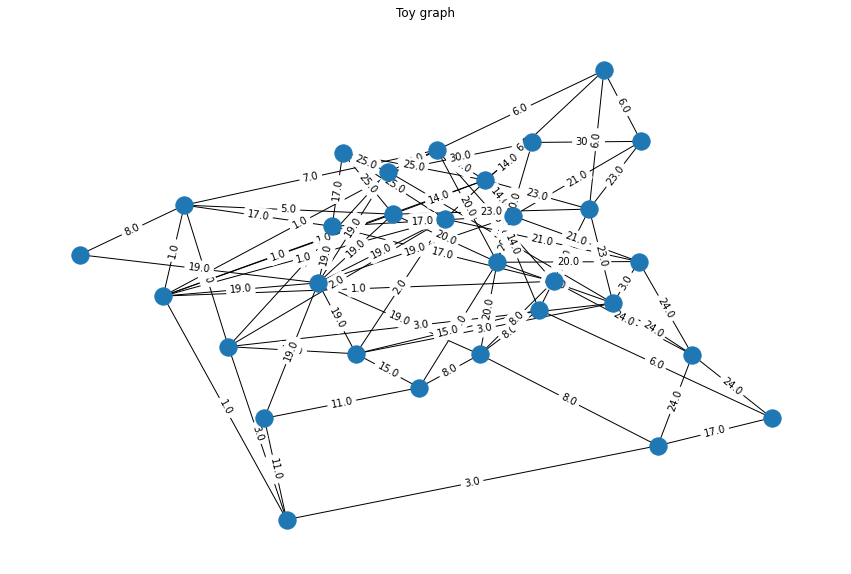

In [30]:
# STUDENT CODE BEGIN

  # Create graph from adjacency matrix
'''
adjacency_matrix = np.array([[0, 3, 2, 0, 0, 0],
                      [3, 0, 2, 0, 0, 0],
                      [2, 2, 0, 1, 0, 0],
                      [0, 0, 1, 0, 2, 2],
                      [0, 0, 0, 2, 0, 3],
                      [0, 0, 0, 2, 3, 0]])
'''

  # Or create graph using a random graph generator
from networkx.generators.random_graphs import erdos_renyi_graph
import random

n = 30
p = 0.2
toy_graph = erdos_renyi_graph(n, p)
adjacency_matrix = nx.convert_matrix.to_numpy_array(toy_graph)
for i in range(len(adjacency_matrix)):
  adjacency_matrix[i] *= random.randint(0, n)

adjacency_sparse_matrix = sparse.csr_matrix(adjacency_matrix)
toy_graph = nx.convert_matrix.from_scipy_sparse_matrix(adjacency_sparse_matrix)

# STUDENT CODE END

plt.figure(figsize=(15, 10))
# Graph visualization functions
def draw_graph_with_weights(G, attribute="weight"):
  pos = nx.spring_layout(G)
  nx.draw(G, pos)
  weights = nx.get_edge_attributes(G,attribute)
  nx.draw_networkx_edge_labels(G,pos,edge_labels=weights)
  plt.show()

def draw_graph_with_weights_and_labels(G, labels, attribute="weight"):
  pos = nx.spring_layout(G)
  nx.draw(G, pos, node_color=labels)
  weights = nx.get_edge_attributes(G,attribute)
  nx.draw_networkx_edge_labels(G,pos,edge_labels=weights)
  plt.show()

# Visualizing the graph
plt.title("Toy graph")
draw_graph_with_weights(toy_graph)

### Clustering the Toy Graph

There are several techniques for clustering graphs. Here, we will see an application of the K-Means, Spectral Clustering, Minimum Spanning Tree Clustering, Normalized Cut and Modularity optimisation.

##### K-Means clustering

One of the simplest techniques for clustering graphs is applying K-Means to its adjacency matrix. We can consider each row of the matrix as a feature vector for the corresponding node.

We will use the method implemented by `scikit-learn`, which takes as input a **NumPy array**. However, bear in mind that K-means has a random initialization; thus, the best strategy is to do several initializations and choose the one with the best inertia.

**2) Question**: what are the effects when increasing the number of clusters? And in more complex graphs?

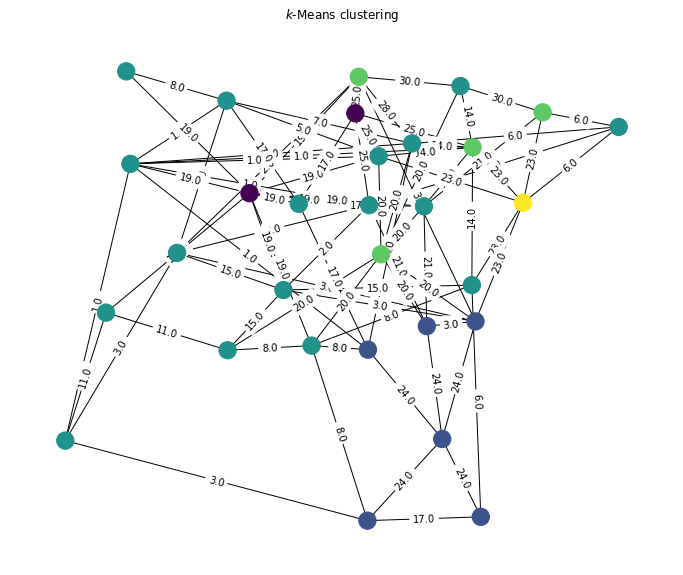

In [41]:
# K-Means clustering
n_clusters = 5
number_of_initialisations = 20

# Using scikit-learn method requires an adjacency matrix
toy_adjacency = nx.convert_matrix.to_numpy_array(toy_graph)
kmeans_cluster = KMeans(n_clusters=n_clusters, n_init=number_of_initialisations).fit(toy_adjacency)
kmeans_predictions = kmeans_cluster.labels_

# Printing the k-Means centers
#print("K-Means centers:", kmeans_cluster.cluster_centers_)
# Drawing the predictions
plt.figure(figsize=(12, 10))
plt.title("$k$-Means clustering")
draw_graph_with_weights_and_labels(toy_graph, kmeans_predictions)

**Answer :** Up until a certain point the result is satisfactory, but then we get to a point where we have most clusters with very few nodes spread across the graph and the ensemble of clusters can't give us much information.

##### Spectral Clustering

**Exercise:** In this part, you will implement the Spectral Clustering algorithm, by following the steps below:

1. Compute the Graph Laplacian. There are multiple definitions for the Graph Laplacian, but the simplest one is the _unnormalized Laplacian_ $L = D-A$, where $D$ is the [degree matrix](https://en.wikipedia.org/wiki/Degree_matrix) of the graph and $A$ the adjacency matrix. Another commonly used definition is the _normalized symmetric Laplacian_ $L_{sym} = I - D^{-1/2}AD^{-1/2}$, provided for convenience.
2. Compute the eigenvectors and corresponding eigenvalues of $L$ (tip: use the provided function).
3. Take the eigenvectors corresponding to the $n_{clusters}$ smallest eigenvalues and stack them column-wise, thus obtaining a $n_{vertices} \times n_{clusters}$ matrix.
4. Compute K-means on this matrix.

You can compare your results with those of the `scikit-learn` implementation, provided in the next cell.

**3) Question:** What are the differences between the unnormalized and the normalized Laplacian?

**Answer :** The normalization of the Laplacian matrix reduces the influence of heavy nodes (nodes with a large degree) in the clustering process, making those nodes' influence closer to that of the other nodes. This is done by dividing the values of the Laplacian matrix by the vertex degrees.

**4) Question:** Compare the behaviour of K-Means and Spectral Clustering with different numbers of clusters, especially in more complex graphs.

**Answer :** The Spectral Clustering algorithm seems to favor the connectivity of the nodes when creating clusters.

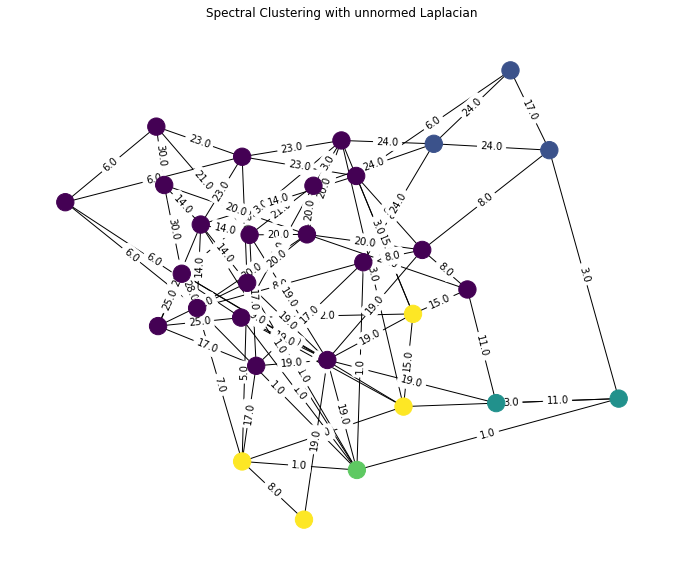

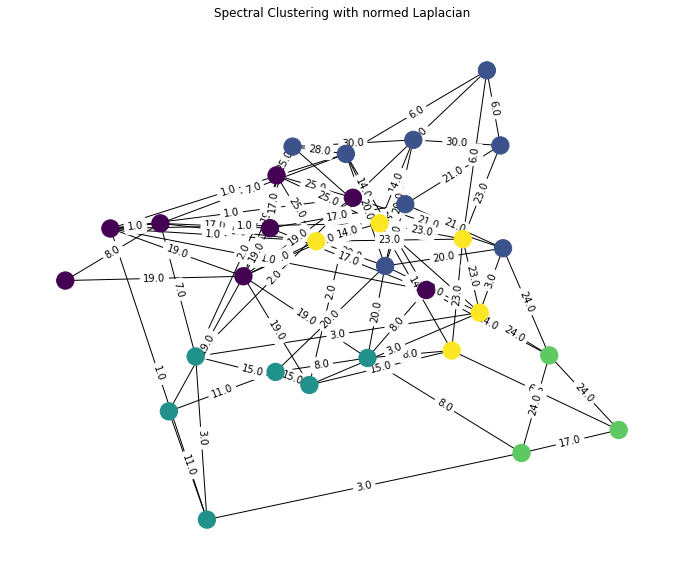

In [40]:
# Spectral clustering
n_clusters = 5
number_of_initialisations = 20

# Normalized Laplacian computation
def norm_laplacian(adjacency):
  return csgraph_laplacian(adjacency, normed=True)

def unnorm_laplacian(adjacency):
  return csgraph_laplacian(adjacency, normed=False)

# Computation of smallest eigenvalues and eigenvectors
def get_first_k_eigenpairs(laplacian, n_clusters):
  laplacian *= -1
  eigenvalues, eigenvectors = eigsh(laplacian, k=n_clusters, sigma=1.0, which='LM')
  return eigenvalues, eigenvectors

# STUDENT CODE BEGIN

toy_adjacency = nx.convert_matrix.to_numpy_array(toy_graph)

L = unnorm_laplacian(toy_adjacency)
eigenvectors = get_first_k_eigenpairs(L, n_clusters)[1]

spectral_cluster = KMeans(n_clusters=n_clusters, n_init=number_of_initialisations).fit(eigenvectors)
spectral_predictions = spectral_cluster.labels_

L2 = norm_laplacian(toy_adjacency)
eigenvectors2 = get_first_k_eigenpairs(L2, n_clusters)[1]

spectral_cluster2 = KMeans(n_clusters=n_clusters, n_init=number_of_initialisations).fit(eigenvectors2)
spectral_predictions2 = spectral_cluster2.labels_

# STUDENT CODE END

# Drawing the predictions
plt.figure(figsize=(12, 10))
plt.title("Spectral Clustering with unnormed Laplacian")
draw_graph_with_weights_and_labels(toy_graph, spectral_predictions)

plt.figure(figsize=(12, 10))
plt.title("Spectral Clustering with normed Laplacian")
draw_graph_with_weights_and_labels(toy_graph, spectral_predictions2)

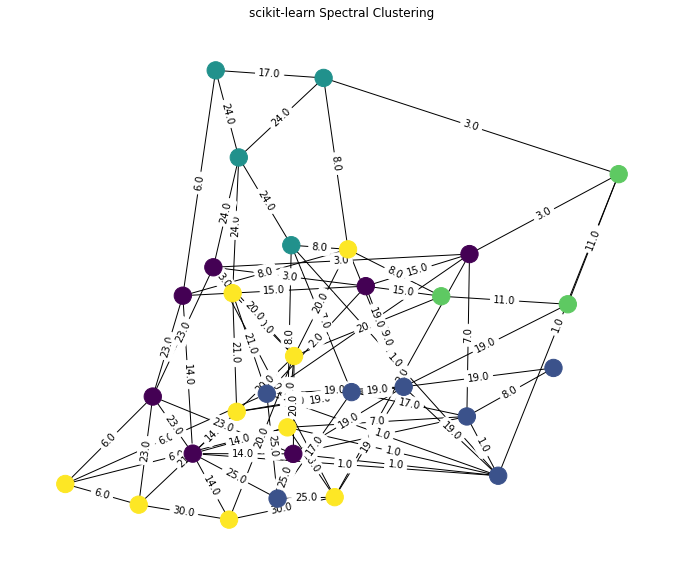

In [43]:
# Using scikit-learn method requires an adjacency matrix
toy_adjacency = nx.convert_matrix.to_numpy_array(toy_graph)
spectral_cluster = SpectralClustering(n_clusters, affinity="precomputed", n_init=number_of_initialisations).fit(toy_adjacency)
spectral_predictions = spectral_cluster.labels_

# Drawing the predictions
plt.figure(figsize=(12, 10))
plt.title("scikit-learn Spectral Clustering")
draw_graph_with_weights_and_labels(toy_graph, spectral_predictions)

##### Minimum/Maximum Spanning Tree Clustering

As seen in class, we can use a Minimum/Maximum Spanning Tree to compute a clustering by suppressing the $(n_{clusters})-1$ most costly/least costly edges.

If we want our clusters to have large weights inside and small weights between each cluster (as is the case in a similarity graph), then we must use the Maximum Spanning Tree. Otherwise, if we want our clusters to have small weights inside and large weights between each cluster (as is the case in a distance graph), then we must use the Minimum Spanning Tree.

After suppressing the edges, each connected component left will correspond to a cluster.

**5) Exercise:** after obtaining a MST from NetworkX's method, supress the most/least costly edges (depending on how you are defining your communities!).

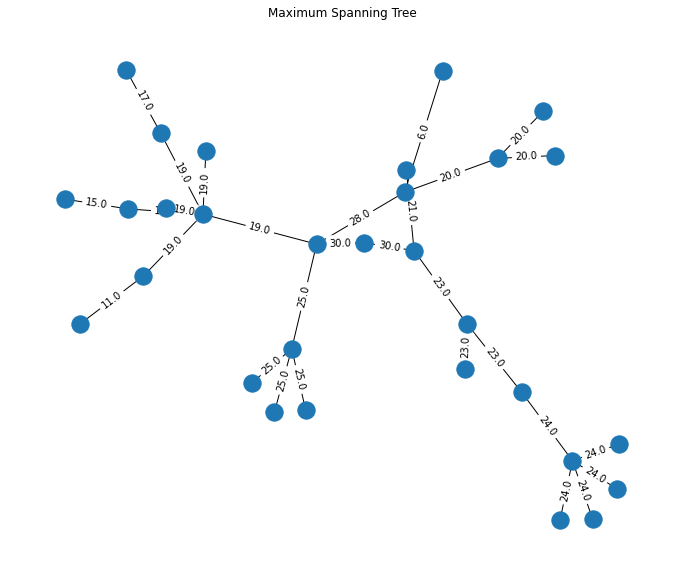

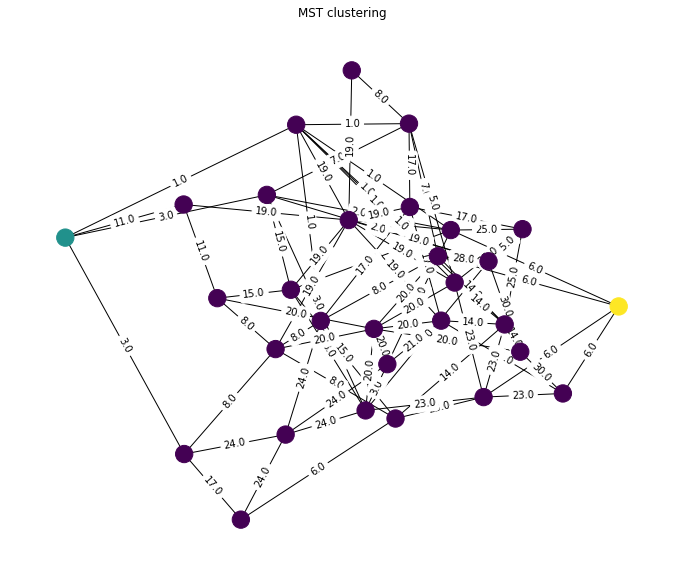

In [54]:
# MST Clustering
n_clusters = 3

# We can use NetworkX's method to find MST
mst = nx.algorithms.tree.mst.maximum_spanning_tree(toy_graph, algorithm="kruskal")
# Visualizing the MST
plt.figure(figsize=(12, 10))
plt.title("Maximum Spanning Tree")
draw_graph_with_weights(mst)
plt.show()

# STUDENT CODE BEGIN
weights = []
for edge in list(mst.edges.data("weight")):
  weights.append(edge[2])

index = np.argsort(weights)
edges = np.array(list(mst.edges.data("weight")))[index]

for i in range(n_clusters-1):
  mst.remove_edge(edges[i][0], edges[i][1])
# STUDENT CODE END

# Getting the connected components
connected_components = nx.algorithms.components.connected_components(mst)

mst_predictions = np.empty(toy_graph.number_of_nodes())
for prediction, node_list in enumerate(connected_components):
  for node in node_list:
    mst_predictions[node] = prediction

# Drawing the predictions
plt.figure(figsize=(12, 10))
plt.title("MST clustering")
draw_graph_with_weights_and_labels(toy_graph, mst_predictions)

##### Modularity optimisation

Modularity is a quality measure for graph clustering [1,2]. Intuitively, high modularity implies that a given graph clustering has large weights _inside_ each cluster, and small weights _between_ each cluster. Additionally, modularity also expects all clusters to have the same _size_, that is, the total sum of intra-cluster weights. This, in turn, means that we can use modularity optimisation to automatically compute the number of clusters in a graph.

For a more mathematical definition: Let's take a simple graph $G=(V,E)$ with $n := |V|$ vertices and $m := |E|$ edges. Denote by $\mathcal{C} = \{C_1,...,C_k\}$ a partition of $V$. We call $\mathcal{C}$ a _clustering_ of $G$ and each $C_i$, which are required to be non-empty, _clusters_. We identify a cluster $C_i$ with the induced subgraph of $G$, i.e. the graph $G[C_i] := (C_i, E(C_i))$ where $E(C_i) := \{\{v,w\} \in E : v,w \in C_i\}$.

We define the _modularity_ $q(\mathcal{C})$ of a clustering $\mathcal{C}$ as:

$$q(\mathcal{C}) = \sum_{C\in\mathcal{C}} \left[ \frac{|E(C)|}{m} - \left( \frac{|E(C)| + \sum_{C' \in \mathcal{C}} |E(C,C')|}{2m} \right)^2 \right ]$$

We will be using `scikit-network`'s Louvain's algorithm [3,4] with Newman's objective function [1,4].

* [1] Newman, Mark EJ. "Modularity and community structure in networks." Proceedings of the national academy of sciences 103.23 (2006): 8577-8582.
* [2] Brandes, Ulrik, et al. "On modularity clustering." IEEE transactions on knowledge and data engineering 20.2 (2007): 172-188.
* [3] Blondel, Vincent D., et al. "Fast unfolding of communities in large networks." Journal of statistical mechanics: theory and experiment 2008.10 (2008): P10008.
* [4] https://scikit-network.readthedocs.io/en/latest/reference/clustering.html

**6) Question:** How does modularity work in larger graphs? Are the results the same as for the Spectral Clustering? Do you consider automatic discovery of the number of clusters an advantage?

**Answer :** In larger graphs, it tends to separate clusters connected through weak nodes. Yes, the automatic discovery of K is an advantage, since it can make the process much more automatic than having to test your results for an arbitrary number of K values.

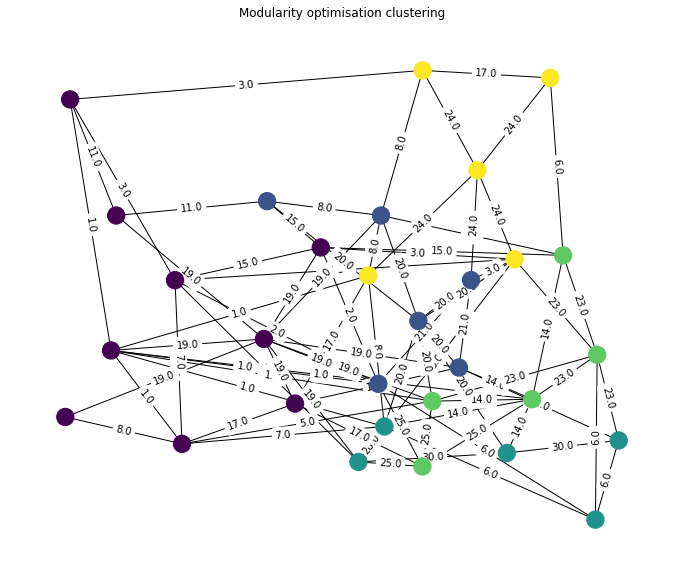

In [45]:
# Modularity optimisation
# Using scikit-network method requires an adjacency matrix
toy_adjacency = nx.convert_matrix.to_numpy_array(toy_graph)
louvain_predictions = Louvain(modularity="newman").fit_transform(toy_adjacency)

# Drawing the predictions
plt.figure(figsize=(12, 10))
plt.title("Modularity optimisation clustering")
draw_graph_with_weights_and_labels(toy_graph, louvain_predictions)

### Working with Real Images: Region Adjacency Graphs

Given an image segmented with an oversegmentation technique such as watershed or superpixels, we can build a region adjacency graph by treating every region as a node and connecting adjacent regions via an edge.

##### Loading and segmenting an image

There are several images available in `skimage.data`. Here are a few examples, so you can switch them out and try the techniques on different images.

There are also many different techniques for segmentation, as can be seen in [Scikit-Image](https://scikit-image.org/docs/dev/api/skimage.segmentation.html). We used SLIC for these examples, but feel free to swap it out with different techniques.

In [9]:
#image = data.astronaut()
image = data.coffee()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  """Entry point for launching an IPython kernel.


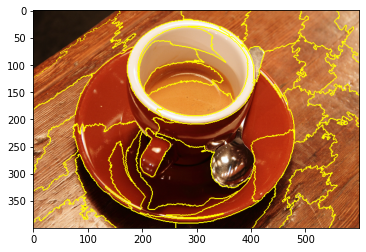

In [10]:
segments_image = segmentation.slic(image, n_segments=50)

plt.imshow(segmentation.mark_boundaries(image, segments_image))
plt.show()

##### Building a Region-Adjacency Graph (RAG)

We use the mean color of region as attribute for nodes. For edge attributes, we have two choices:
1. Euclidean distance between the mean color of two connected nodes as the edge weight. This means that neighboring regions with very different colors will have a strong edge between them.
2. Similarity between the mean color of two connected nodes as the edge weight. This means that neighboring regions with very different colors will have weak edges between them. Similarity is computed as $e^{-d^2/sigma}$, where $d$ is the Euclidean distance between the mean colors.

In [11]:
# Creating the RAG using scikit-image's function.
#  Note that this is a NetworkX graph object where the nodes have an attribute
#  "mean color" and the edges have an attribute "weight" which is the distance
#  or similarity between the mean color of two adjacent regions.
rag_distance = skgraph.rag_mean_color(image, segments_image, mode="distance")
rag_similarity = skgraph.rag_mean_color(image, segments_image, mode="similarity", sigma=512)

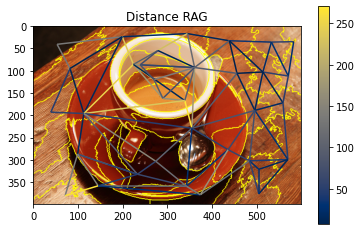

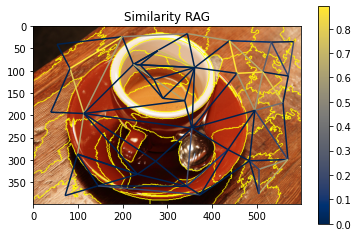

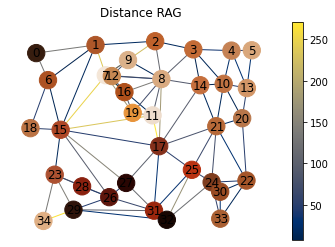

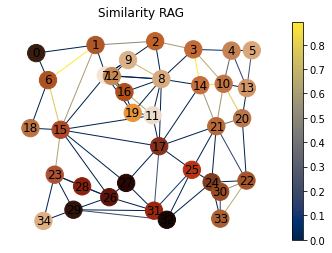

In [12]:
## Visualizing with scikit-image
lines = skgraph.show_rag(segments_image, rag_distance, image, border_color="yellow", edge_cmap=plt.get_cmap("cividis"), img_cmap=None)
plt.colorbar(lines)
plt.title("Distance RAG")
plt.show()
lines = skgraph.show_rag(segments_image, rag_similarity, image, border_color="yellow", edge_cmap=plt.get_cmap("cividis"), img_cmap=None)
plt.colorbar(lines)
plt.title("Similarity RAG")
plt.show()

# Visualizing with NetworkX - we need to get the mean colors from the nodes
# We use the edge weights to compute the alpha of the edges
# And for a better visualization, we can draw the nodes on the region centroids
def draw_rag(label, rag, image):
  region_centroids_dict = {props_per_label["label"]-1: 
                           [props_per_label["centroid"][1],image.shape[1]-props_per_label["centroid"][0]] 
                           for props_per_label in regionprops(label+1)}  # the +1 is there because labels 0 are ignored
  mean_colors = [node_color[1]/256 for node_color in rag.nodes.data("mean color")]
  edge_weights = [edge_weight[2] for edge_weight in rag.edges.data("weight")]
  nx.draw(rag, 
          pos=region_centroids_dict, 
          with_labels=True,
          node_color=mean_colors, 
          edge_color=edge_weights, edge_cmap=plt.get_cmap("cividis"))
  plt.colorbar(plt.cm.ScalarMappable(cmap=plt.get_cmap("cividis"), norm=plt.Normalize(vmin=min(edge_weights), vmax=max(edge_weights))))

# This visualisation function shows a relabeled image, as well as the corresponding clustered RAG
def draw_labels_and_rag(image, labels):
  plt.imshow(segmentation.mark_boundaries(image, labels))
  plt.show()

  # We can even show the cut RAG
  cut_rag = skgraph.rag_mean_color(image, labels, mode="distance")
  draw_rag(labels, cut_rag, image)
  plt.show()


plt.title("Distance RAG")
draw_rag(segments_image, rag_distance, image)
plt.show()
plt.title("Similarity RAG")
draw_rag(segments_image, rag_similarity, image)
plt.show()

# Visualizing as a weighted adjacency matrix
#adjacency_matrix = nx.convert_matrix.to_numpy_array(rag_distance)
#print("Distance RAG Adjacency Matrix")
#print(pd.DataFrame(adjacency_matrix))
#adjacency_matrix = nx.convert_matrix.to_numpy_array(rag_similarity)
#print("Similarity RAG Adjacency Matrix")
#print(pd.DataFrame(adjacency_matrix))

#### Clustering the RAG 

We can now apply the techniques seen in the previous exercise to the RAG. We can then remap all clustered regions to the image, to better analyse the performance of the algorithm.

##### Threshold Cut
A very simple technique for clustering a region-adjacency graph is cutting (removing) every edge whose weight is above a certain value (for the distance RAG) or below a certain value (for the similarity RAG). The connected components that are left each correspond to a different cluster.

**7) Exercise:** implement a threshold cut algorithm. You can choose between using the similarity or the distance RAG (Tip: for the connected components, check out `nx.connected_components()`).  Have it output a `predictions` list, where for every node of the RAG, you have the value of the predicted cluster. Example: if the node "10" belongs to cluster "2", `predictions[10] = 2`.

Compare your implementation's results with `skgraph.cut_threshold` - be mindful that this technique only cuts edges above the threshold; if you are using the similarity graph, you will need to invert this by hand.

**Answer :** The implementation results are the same for the hand-crafted algorithm and the scikit-image one.

Scikit-image cut_threshold at 60


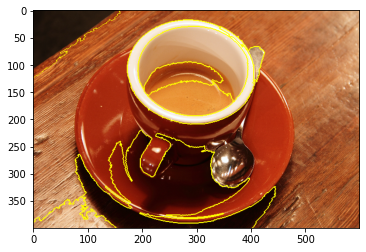

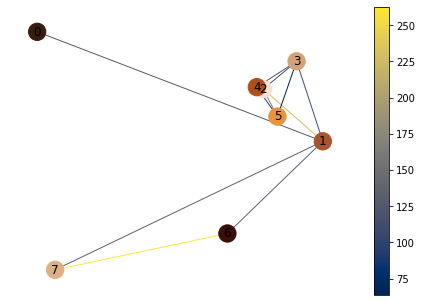

Hand-crafted cut_threshold at 60


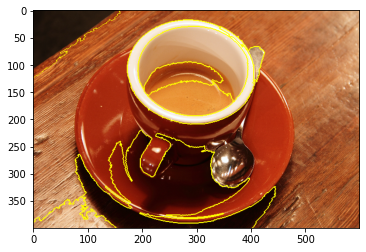

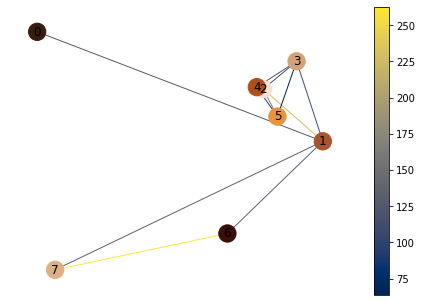

In [46]:
# Threshold cut
rag_distance2 = rag_distance.copy()
threshold = 60

# Threshold cut using scikit-image
# This also directly outputs the labels image
labels1 = skgraph.cut_threshold(segments_image, rag_distance2, threshold, in_place=False)

print("Scikit-image cut_threshold at {}".format(threshold))
draw_labels_and_rag(image, labels1)

# STUDENT CODE BEGIN

for edge in list(rag_distance2.edges.data("weight")):
  if(edge[2] > threshold):
    rag_distance2.remove_edge(edge[0], edge[1])

connected_components = nx.algorithms.components.connected_components(rag_distance2)

rag_distance_predictions = np.empty(rag_distance2.number_of_nodes())
for prediction, node_list in enumerate(connected_components):
  for node in node_list:
    rag_distance_predictions[node] = prediction
# STUDENT CODE END

# Mapping the original labels image to a new one
labels2 = rag_distance_predictions[segments_image].astype(int)

print("Hand-crafted cut_threshold at {}".format(threshold))
draw_labels_and_rag(image, labels2)

##### K-Means Clustering

We can perform K-Means clustering similarly to how we did with the toy graph.

We recommend using the similarity RAG for K-Means.

**8) Question:** Experiment with different numbers of clusters. How many clusters are necessary for you to consider the segmentation satisfactory?

**Answer :** 10 clusters is good enough. We get a good adherence to the edges separating the coffee plate and cup from the table, except in the region below the cup where there's a strong shadow.

KMeans with 10 clusters


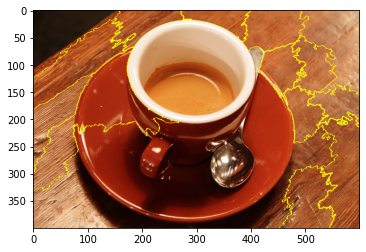

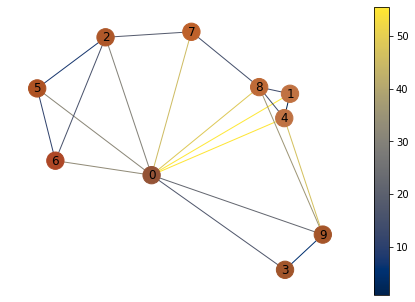

In [50]:
# K-Means clustering
n_clusters = 10
number_of_initialisations = 20

# Using scikit-learn method requires an adjacency matrix
adjacency_matrix = nx.convert_matrix.to_numpy_array(rag_similarity)
kmeans_cluster = KMeans(n_clusters=n_clusters, n_init=number_of_initialisations).fit(adjacency_matrix)
kmeans_predictions = kmeans_cluster.labels_

# Mapping the original labels image to a new one
labels3 = kmeans_predictions[segments_image].astype(int)

print("KMeans with {} clusters".format(n_clusters))
draw_labels_and_rag(image, labels3)


##### Spectral Clustering

We can perform Spectral Clustering using the same techniques we used for the toy graph. We recommend using the similarity RAG.

**9) Question:** how does Spectral Clustering compare to K-Means, when using the same number of clusters?

**Answer :** I didn't quite understand the "Use your previosuly developed function here!" line, since the code for the question is given. Comparing the results visually, it looks like the Spectral Clustering tends to favor color homogeneity more than the K-Means, in a way that we can have big regions where the color is homogene.

Spectral Clustering with 9 clusters


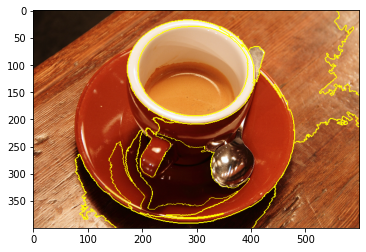

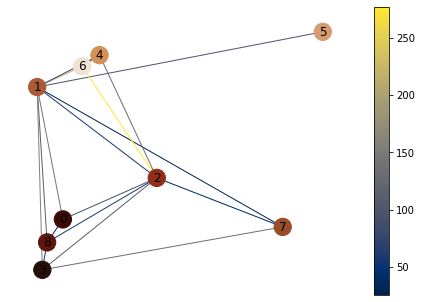

In [51]:
# Spectral clustering
n_clusters = 9

# Use your previously developed function here!
# STUDENT CODE BEGIN
# STUDENT CODE ENDS

# Using scikit-learn method requires an adjacency matrix
adjacency_matrix = nx.convert_matrix.to_numpy_array(rag_similarity)
spectral_cluster = SpectralClustering(n_clusters, affinity="precomputed").fit(adjacency_matrix)
spectral_predictions = spectral_cluster.labels_

# Mapping the original labels image to a new one
labels4 = spectral_predictions[segments_image].astype(int)

print("Spectral Clustering with {} clusters".format(n_clusters))
draw_labels_and_rag(image, labels4)

##### Modularity clustering 
We can perform Modularity Clustering using the same techniques we used for the toy graph. We recommend using the similarity RAG.

**10) Question:** Do you consider the number of clusters automatically found by Louvain's algorithm to be good? If you apply this number of clusters to Spectral Clustering, are the results better than Modularity optimisation or worse?

**Answer :** Yes, it's a good number of clusters that when applied to the Spectral Clustering we get almost the same result.

Louvain clustering


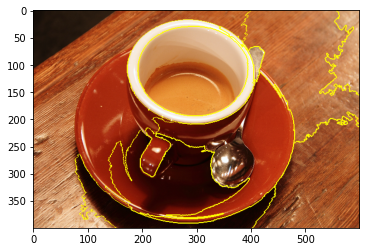

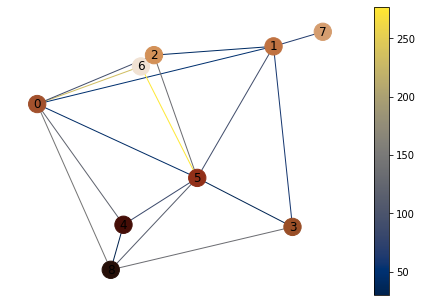

In [17]:
# Louvain modularity clustering

# Using scikit-network method requires an adjacency matrix
adjacency_matrix = nx.convert_matrix.to_numpy_array(rag_similarity)
louvain_predictions = Louvain(modularity="newman").fit_transform(adjacency_matrix)

# Mapping the original labels image to a new one
labels5 = louvain_predictions[segments_image].astype(int)

print("Louvain clustering")
draw_labels_and_rag(image, labels5)

##### Minimum spanning tree clustering

We can perform Minimum/Maximum Spanning Tree Clustering using the same techniques we used for the toy graph. If using the Minimum Spanning Tree, use the distance RAG. Otherwise, if using the Maximum Spanning Tree, use the similarity RAG.

**11) Question:** are there any differences between using the Minimum tree on the distance RAG and the Maximum tree on the similarity RAG?

**Answer :** No, we can see below that we get the same result for both cases.

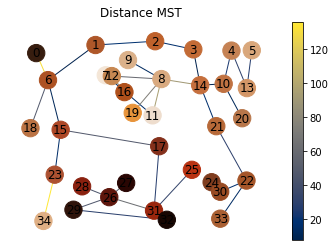

MST clustering


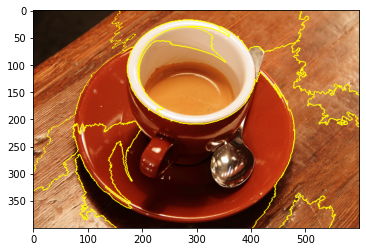

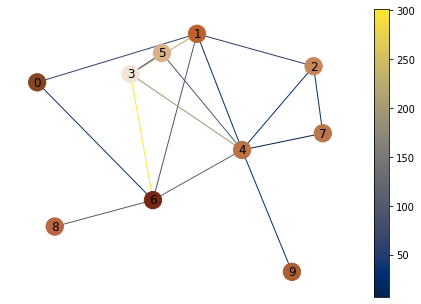

In [59]:
# Minimum spanning tree clustering
n_clusters = 10

# We can use NetworkX's method to find MST using either "kruskal" or "prim" algorithms
mst = nx.algorithms.tree.mst.minimum_spanning_tree(rag_distance, algorithm="kruskal")
# Visualizing the MST
plt.title("Distance MST")
draw_rag(segments_image, mst, image)
plt.show()

# Use your previously developed function here!
weights = []
for edge in list(mst.edges.data("weight")):
  weights.append(edge[2])

index = np.argsort(weights)
edges = np.array(list(mst.edges.data("weight")))[index]

for i in range(n_clusters-1):
  mst.remove_edge(edges[i][0], edges[i][1])

# Getting the connected components
connected_components = nx.algorithms.components.connected_components(mst)

mst_predictions = np.empty(rag_distance.number_of_nodes())
for prediction, node_list in enumerate(connected_components):
  for node in node_list:
    mst_predictions[node] = prediction
# STUDENT CODE ENDS

# Mapping the original labels image to a new one
labels6 = mst_predictions[segments_image].astype(int)

print("MST clustering")
draw_labels_and_rag(image, labels6)

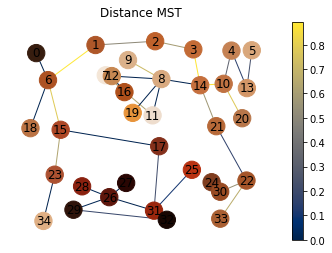

MST clustering


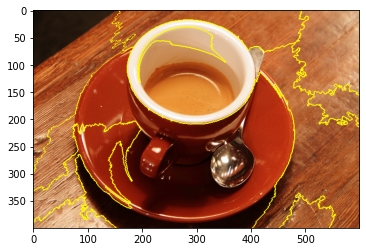

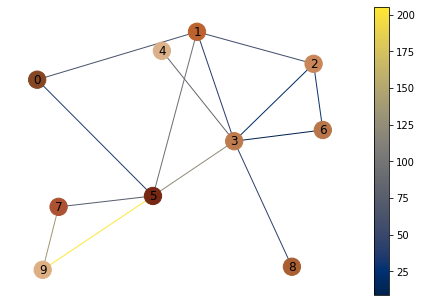

In [63]:
# Minimum spanning tree clustering
n_clusters = 10

# We can use NetworkX's method to find MST using either "kruskal" or "prim" algorithms
mst = nx.algorithms.tree.mst.maximum_spanning_tree(rag_similarity, algorithm="kruskal")
# Visualizing the MST
plt.title("Distance MST")
draw_rag(segments_image, mst, image)
plt.show()

# Use your previously developed function here!
weights = []
for edge in list(mst.edges.data("weight")):
  weights.append(edge[2])

index = np.argsort(weights)
edges = np.array(list(mst.edges.data("weight")))[index]

for i in range(n_clusters-1):
  mst.remove_edge(edges[-i][0], edges[-i][1])

# Getting the connected components
connected_components = nx.algorithms.components.connected_components(mst)

mst_predictions = np.empty(rag_distance.number_of_nodes())
for prediction, node_list in enumerate(connected_components):
  for node in node_list:
    mst_predictions[node] = prediction
# STUDENT CODE ENDS

# Mapping the original labels image to a new one
labels6 = mst_predictions[segments_image].astype(int)

print("MST clustering")
draw_labels_and_rag(image, labels6)

## Graph Matching

In this part, we will learn how to match two graphs.

### Association Graph Maximal Clique

We will use two different photos of the same table, with the same objects, as our data. The segmentation is already given. From the segmentation, we will build a Region-Adjacency Graph.

In [64]:
# Downloading the images
!wget "https://partage.imt.fr/index.php/s/MBM7QXKxnWRWC9P/preview" -O "image1.png" -nv
!wget "https://partage.imt.fr/index.php/s/QDJCBBgkAzDo63k/preview" -O "image2.png" -nv

2022-01-30 20:15:40 URL:https://partage.imt.fr/index.php/s/MBM7QXKxnWRWC9P/preview [2589/2589] -> "image1.png" [1]
2022-01-30 20:15:41 URL:https://partage.imt.fr/index.php/s/QDJCBBgkAzDo63k/preview [2557/2557] -> "image2.png" [1]


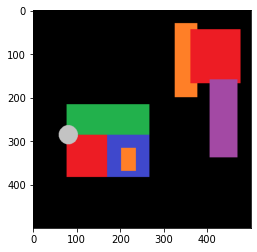

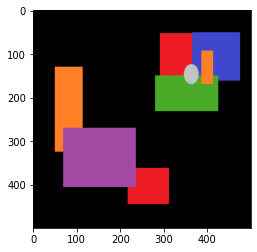

In [65]:
# Loading the images
image1, image2 = io.imread("image1.png")[:,:,:3], io.imread("image2.png")[:,:,:3]  # We remove the Alpha channel

plt.imshow(image1)
plt.show()
plt.imshow(image2)
plt.show()

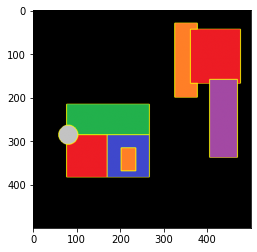

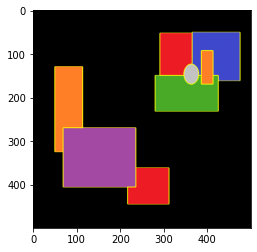

In [66]:
# Computing segmentations
segments_image1 = sklabel((255*color.rgb2gray(image1)).astype(np.uint8))
segments_image2 = sklabel((255*color.rgb2gray(image2)).astype(np.uint8))

plt.imshow(segmentation.mark_boundaries(image1, segments_image1))
plt.show()
plt.imshow(segmentation.mark_boundaries(image2, segments_image2))
plt.show()

In [67]:
# Creating the RAGs using scikit-image's function.
# We can use either the distance or the similarity RAGs.
rag_image1 = skgraph.rag_mean_color(image1, segments_image1, mode="similarity", sigma=512)
rag_image2 = skgraph.rag_mean_color(image2, segments_image2, mode="similarity", sigma=512)

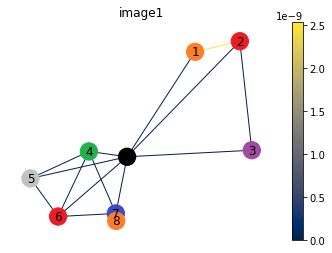

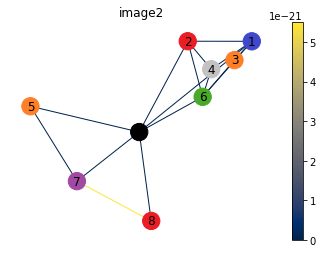

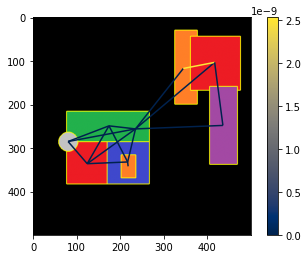

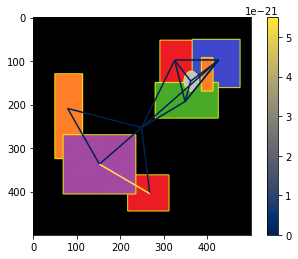

In [68]:
plt.title("image1")
draw_rag(segments_image1, rag_image1, image1)
plt.show()

plt.title("image2")
draw_rag(segments_image2, rag_image2, image2)
plt.show()

lines = skgraph.show_rag(segments_image1, rag_image1, image1, border_color="yellow", edge_cmap=plt.get_cmap("cividis"), img_cmap=None)
plt.colorbar(lines)
plt.show()
lines = skgraph.show_rag(segments_image2, rag_image2, image2, border_color="yellow", edge_cmap=plt.get_cmap("cividis"), img_cmap=None)
plt.colorbar(lines)
plt.show()

##### Building the Association Graph

**12) Exercise:** build an association graph between both RAGs.

To build the association graph between these two RAGs, we need to follow the steps below:

1. Compute the association node mapping:
  * A node from the a RAG is associated to a node in the other RAG if their values (that is, mean color) are "close enough", that is, the distance between them is below a certain threshold.
  * Tip: the mean color of a node in a RAG can be accessed by the keyword `"mean color"`; try looking at the result of `rag_image1.nodes(data="mean color")`
  * Tip: you can use the "luminance" function provided to convert a RGB mean color tuple to a single scalar value, for comparison.
  * Tip: in NetworkX, the "name" of a node can be anything, including a tuple. `association_graph.add_node([node1, node2])` will add a node named `[node1, node2]`.
2. Compute the association edge mapping:
  * An edge from a RAG is associated to an edge in the second RAG if both of their connecting nodes are also associated, and if the weights of the edges are "close enough".
  * Tip: You can access the weight of an edge by using `rag_image1.edges[node1, node2]["weight"]`.

In [84]:
rag_image1.edges

EdgeView([(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 7), (0, 6), (1, 2), (2, 3), (4, 5), (4, 6), (4, 7), (5, 6), (6, 7), (7, 8)])

In [113]:
rag_image2.edges

EdgeView([(0, 1), (0, 2), (0, 5), (0, 6), (0, 7), (0, 8), (1, 2), (1, 3), (1, 4), (1, 6), (2, 4), (2, 6), (3, 6), (4, 6), (5, 7), (7, 8)])

In [123]:
association_graph.nodes

NodeView(((0, 0), (1, 3), (1, 5), (1, 6), (2, 1), (2, 2), (2, 8), (3, 7), (4, 3), (4, 5), (4, 6), (5, 4), (6, 1), (6, 2), (6, 8), (7, 1), (7, 2), (7, 8), (8, 3), (8, 5), (8, 6)))

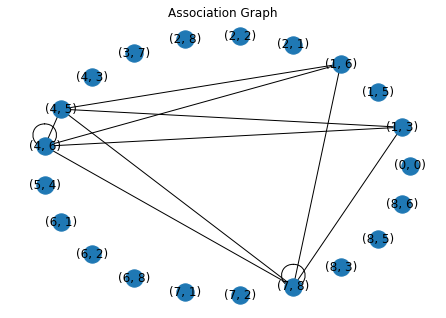

In [179]:
# Building the association graph
node_max_delta = 15  # This is the maximum allowed distance between node values so they can be considered associated
edge_max_delta = 0.15  # Ditto for edges

# For comparing node values we'll use the luminance
def luminance(color_tuple):
  r,g,b = color_tuple
  return (0.2126*r + 0.7152*g + 0.0722*b)

# STUDENT CODE BEGIN
association_graph = nx.Graph()
for nodeIm1 in rag_image1.nodes:
  node1 = rag_image1.nodes[nodeIm1]
  for nodeIm2 in rag_image2.nodes:
    node2 = rag_image2.nodes[nodeIm2]
    if np.abs(luminance(node1['mean color']) - luminance(node2['mean color'])) <= node_max_delta:
        association_graph.add_node((node1['labels'][0], node2['labels'][0]))

nodeList = list(association_graph.nodes)
for edgeIm1 in rag_image1.edges:
  w1 = rag_image1.edges[edgeIm1[0], edgeIm1[1]]['weight']
  for edgeIm2 in rag_image2.edges:
    w2 = rag_image2.edges[edgeIm2[0], edgeIm2[1]]['weight']
    if edgeIm1 in nodeList and edgeIm2 in nodeList and (np.abs(w1 - w2) <= edge_max_delta):
      association_graph.add_edge(edgeIm1, edgeIm2)

# STUDENT CODE END

nx.draw(association_graph, pos=nx.circular_layout(association_graph), with_labels=True)
plt.title("Association Graph")
plt.show()

##### Finding the maximal clique

**13) Exercise:** from the built association graph, find all of the largest cliques.

We can use NetworkX's `find_cliques` algorithm to find all cliques in the association graph. We then choose the largest cliques found as our subgraph isomorphism candidates.

In [186]:
# Finding all cliques
association_cliques = list(nx.algorithms.clique.find_cliques(association_graph))
# Finding largest cliques
# BEGIN STUDENT CODE
maxSize = 1
largestList = []
for clique in association_cliques:
  if len(clique) > maxSize:
    maxSize = len(clique)
    largestList = [clique]
  elif len(clique) == maxSize:
    largestList.append(clique)

# END STUDENT CODE

[(4, 5), (4, 6), (7, 8), (1, 6)]

**14) Exercise:** Choose the "best" candidate available.

To find which candidate to use, we can score the candidates by some metric, such as the differences in sizes or colors of the matched objects.

In [ ]:
# BEGIN STUDENT CODE


# END STUDENT CODE